Semana 9 - Reto Calidad del agua

* Lázaro Lara Martínez. Matricula A01793198
* José Mtanous Treviño. Matricula A00169781

Ciencia y Analítica de datos.

Profesor Titular.
Profesor Tutor. Mtro. Mario Alberto Solano Saldaña

14/Noviembre/2022


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
import geopandas
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.compose import TransformedTargetRegressor

from sklearn.metrics import f1_score, precision_score,confusion_matrix, plot_roc_curve,RocCurveDisplay,recall_score, make_scorer,accuracy_score
from sklearn.preprocessing import LabelEncoder
from scipy.stats import alpha
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from numpy.lib.shape_base import vsplit
from sklearn import tree
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RepeatedKFold


#### Selecciona tus variables independientes X y dependiente Y (semáforo)

In [5]:
# cargamos nuestro dataset y lo inspeccionamos rapídamente
path_calidad_subterranea = '../Reto/datos/Escalas_subterranea_clean_sin_numericas.csv'
dfCalidadSubterranea = pd.read_csv(path_calidad_subterranea)

In [6]:
dfCalidadSubterranea.head()

,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,ACUIFERO,SUBTIPO,LONGITUD,LATITUD,CALIDAD_ALC,CALIDAD_CONDUC,CALIDAD_SDT_ra,...,CUMPLE_CON_DUR,CUMPLE_CON_CF,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_CD,CUMPLE_CON_CR,CUMPLE_CON_HG,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE
0,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,ASIENTOS,VALLE DE CHICALOTE,POZO,-102.02210,22.20887,Alta,Permisible para riego,Cultivos sensibles,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
1,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,AGUASCALIENTES,VALLE DE CHICALOTE,POZO,-102.20075,21.99958,Alta,Buena para riego,Excelente para riego,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
2,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,COSIO,VALLE DE AGUASCALIENTES,POZO,-102.28801,22.36685,Alta,Buena para riego,Excelente para riego,...,SI,SI,SI,NO,SI,SI,SI,SI,SI,SI
3,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,VALLE DE AGUASCALIENTES,POZO,-102.29449,22.18435,Alta,Buena para riego,Excelente para riego,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
4,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LA PAZ,TODOS SANTOS,POZO,-110.24480,23.45138,Alta,Permisible para riego,Cultivos con manejo especial,...,SI,SI,NO,SI,SI,SI,SI,SI,SI,SI


In [7]:
dfCalidadSubterranea.columns

Index(['ORGANISMO_DE_CUENCA', 'ESTADO', 'MUNICIPIO', 'ACUIFERO', 'SUBTIPO',
       'LONGITUD', 'LATITUD', 'CALIDAD_ALC', 'CALIDAD_CONDUC',
       'CALIDAD_SDT_ra', 'CALIDAD_SDT_salin', 'CALIDAD_FLUO', 'CALIDAD_DUR',
       'CALIDAD_COLI_FEC', 'CALIDAD_N_NO3', 'CALIDAD_AS', 'CALIDAD_CD',
       'CALIDAD_CR', 'CALIDAD_HG', 'CALIDAD_PB', 'CALIDAD_MN', 'CALIDAD_FE',
       'SEMAFORO', 'CONTAMINANTES', 'CUMPLE_CON_ALC', 'CUMPLE_CON_COND',
       'CUMPLE_CON_SDT_ra', 'CUMPLE_CON_SDT_salin', 'CUMPLE_CON_FLUO',
       'CUMPLE_CON_DUR', 'CUMPLE_CON_CF', 'CUMPLE_CON_NO3', 'CUMPLE_CON_AS',
       'CUMPLE_CON_CD', 'CUMPLE_CON_CR', 'CUMPLE_CON_HG', 'CUMPLE_CON_PB',
       'CUMPLE_CON_MN', 'CUMPLE_CON_FE'],
      dtype='object')

In [8]:
dfCalidadSubterranea = dfCalidadSubterranea.apply(LabelEncoder().fit_transform)
dfCalidadSubterranea

,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,ACUIFERO,SUBTIPO,LONGITUD,LATITUD,CALIDAD_ALC,CALIDAD_CONDUC,CALIDAD_SDT_ra,...,CUMPLE_CON_DUR,CUMPLE_CON_CF,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_CD,CUMPLE_CON_CR,CUMPLE_CON_HG,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE
0,6,0,25,232,5,551,506,1,5,2,...,2,1,2,1,1,1,1,1,1,1
1,6,0,9,232,5,526,490,1,1,4,...,2,1,2,1,1,1,1,1,1,1
2,6,0,94,228,5,517,512,1,1,4,...,2,1,2,0,1,1,1,1,1,1
3,6,0,284,228,5,516,504,1,1,4,...,2,1,2,1,1,1,1,1,1,1
4,10,2,197,220,5,128,583,1,5,1,...,2,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063,12,18,204,42,5,739,701,1,2,1,...,1,1,1,1,1,1,1,1,1,1
1064,12,18,204,42,5,729,706,1,1,4,...,2,1,1,1,1,1,1,1,1,1
1065,12,18,45,41,5,721,811,1,2,1,...,1,1,1,1,1,1,1,1,1,1
1066,12,18,134,137,5,696,713,1,5,2,...,2,1,2,1,1,1,1,1,1,1


Selecciona tus variables independientes X y dependiente Y (semáforo)

In [9]:
#Asignación de variables de entrada y salida
features = ['ORGANISMO_DE_CUENCA', 'ESTADO', 'MUNICIPIO', 'ACUIFERO', 'SUBTIPO','LONGITUD', 'LATITUD', 'CALIDAD_ALC', 'CALIDAD_CONDUC',
       'CALIDAD_SDT_ra', 'CALIDAD_SDT_salin', 'CALIDAD_FLUO', 'CALIDAD_DUR','CALIDAD_COLI_FEC', 'CALIDAD_N_NO3', 'CALIDAD_AS', 'CALIDAD_CD',
       'CALIDAD_CR', 'CALIDAD_HG', 'CALIDAD_PB', 'CALIDAD_MN', 'CALIDAD_FE', 'CONTAMINANTES', 'CUMPLE_CON_ALC', 'CUMPLE_CON_COND',
       'CUMPLE_CON_SDT_ra', 'CUMPLE_CON_SDT_salin', 'CUMPLE_CON_FLUO','CUMPLE_CON_DUR', 'CUMPLE_CON_CF', 'CUMPLE_CON_NO3', 'CUMPLE_CON_AS',
       'CUMPLE_CON_CD', 'CUMPLE_CON_CR', 'CUMPLE_CON_HG', 'CUMPLE_CON_PB','CUMPLE_CON_MN', 'CUMPLE_CON_FE']
X=dfCalidadSubterranea.loc[:,features]
Y= dfCalidadSubterranea.loc[:,['SEMAFORO']]
dfCalidadSubterranea.shape

(1068, 39)

Cambia a label encoding el semáforo, ej, de ["clase 1", "clase 2", "clase 3"] a [ 1,2,3]

In [10]:
Y

,SEMAFORO
0,2
1,2
2,1
3,2
4,1
...,...
1063,1
1064,1
1065,1
1066,2


In [11]:
#Particiòn de datos de entrenamiento y validación. 100 datos de prueba representa el 15%
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=0.80, random_state=0)

In [12]:
#Verificación del tamaño de conjuntos de entrenamiento y prueba
print(Xtest.shape)
print(Xtrain.shape)

(214, 38)
(854, 38)


In [13]:
X.describe()

,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,ACUIFERO,SUBTIPO,LONGITUD,LATITUD,CALIDAD_ALC,CALIDAD_CONDUC,CALIDAD_SDT_ra,...,CUMPLE_CON_DUR,CUMPLE_CON_CF,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_CD,CUMPLE_CON_CR,CUMPLE_CON_HG,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE
count,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,...,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000
mean,5.942884,16.394195,218.425094,144.603933,4.946629,532.775281,532.640449,1.654494,3.012172,2.844569,...,1.786517,0.942884,1.921348,0.881086,0.998127,0.985955,0.999064,0.988764,0.919476,0.872659
std,3.701556,9.975464,122.255709,74.606330,0.435059,307.716206,308.240275,1.181515,1.875417,1.184957,...,0.412238,0.232173,0.272778,0.323839,0.043254,0.117731,0.030600,0.105452,0.272231,0.333511
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,9.000000,124.750000,88.750000,5.000000,266.750000,265.750000,1.000000,1.000000,2.000000,...,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,6.000000,15.000000,211.500000,153.000000,5.000000,532.500000,532.500000,1.000000,3.000000,3.000000,...,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,10.000000,25.000000,313.000000,206.000000,5.000000,799.250000,799.250000,2.000000,5.000000,4.000000,...,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,12.000000,31.000000,451.000000,272.000000,7.000000,1065.000000,1066.000000,4.000000,5.000000,5.000000,...,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
#Estan desbalanceadas las clases.

Y.describe()

,SEMAFORO
count,1068.000000
mean,1.175094
std,0.779456
min,0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2.000000


In [15]:
#Modelo Dummy
modelo_Dummy = DummyClassifier (strategy="stratified")
#Pipeline con modelo Dummy
pipeline_salida = Pipeline(steps=[('modelo_D',modelo_Dummy)])
#Preparación de salida con el pipeline de transformación considerando modelo Dummy
salida_preparada = TransformedTargetRegressor ( regressor = pipeline_salida)

In [16]:

#Se obtienen los conjuntos Dummy
XtrainDummy, XtestDummy, YtrainDummy, YtestDummy = train_test_split(Xtrain, Ytrain, train_size=0.80)

In [17]:
#Preparación variables de entrada con los imputadores
pipeline_In = Pipeline(steps=[('modelo',modelo_Dummy)])
#Preparación variables de salida con la transformación logarítimica.
pipeline_Out= TransformedTargetRegressor(regressor=pipeline_In)

#Predicción de datos con variables de entrenamiento y de prueba del conjunto Dummy
pipeline_Out.fit(XtrainDummy, YtrainDummy)
Yhat_testDummy = pipeline_Out.predict(XtestDummy)
Yhat_trainDummy= pipeline_Out.predict(XtrainDummy)
#Impresión de los resultados de Entrenamiento Dummy


print('\n-----------Resultados Dummy -- Datos de Entrenamiento---------')
names = ['accuracy','f1-score', 'precision', 'recall']
print("\n\t\t  %s\t\t%s   \t\t%s  \t\t%s" % (names[0],names[1],names[2],names[3]))
print("\t\t %.1f  \t\t%.1f   \t\t%.1f  \t\t%.1f" % (
                                            accuracy_score(YtrainDummy, Yhat_trainDummy),
                                            f1_score(YtrainDummy, Yhat_trainDummy, average='weighted'),
                                            precision_score(YtrainDummy, Yhat_trainDummy, average='weighted'),
                                            recall_score(YtrainDummy, Yhat_trainDummy, average='weighted')
                                             ),"%")
#Impresión de los resultados de Validación Dummy
print('\n-----------Resultados Dummy -- Datos de Prueba---------')
print("\n\t\t  %s\t\t%s   \t\t%s  \t\t%s" % (names[0],names[1],names[2], names[3]))
print(" \t\t %.1f  \t\t%.1f   \t\t%.1f   \t\t%.1f" % (
                                             accuracy_score(YtestDummy, Yhat_testDummy),
                                             f1_score(YtestDummy, Yhat_testDummy,average='weighted'),
                                             precision_score(YtestDummy, Yhat_testDummy,average='weighted'),
                                             recall_score(YtestDummy, Yhat_testDummy,average='weighted')
                                             ),"%")


-----------Resultados Dummy -- Datos de Entrenamiento---------

		  accuracy		f1-score   		precision  		recall
		 0.4  		0.4   		0.4  		0.4 %

-----------Resultados Dummy -- Datos de Prueba---------

		  accuracy		f1-score   		precision  		recall
 		 0.3  		0.3   		0.3   		0.3 %


In [18]:
mi_kfoldCV = RepeatedKFold(n_splits=5, n_repeats=3)

modelo = DecisionTreeClassifier()

parameters = {
'criterion' : ['gini', 'entropy'],
'max_depth':range(1,10),
'min_samples_split':range(2,10),
'min_samples_leaf':range(1,10),
}

#Definimos el grid search.
gridFinal=  GridSearchCV (estimator =  modelo,
                        param_grid = parameters,
                        cv = mi_kfoldCV)

#El fit es como feed, para alimentar con los datos de entrada y de salida

gridFinal.fit(Xtrain, Ytrain)
#Tanto best score, como best params, son metodos especfificos predefinidos de las librerias
print(gridFinal.best_score_)
print(gridFinal.best_params_)

0.9925857126476321
{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 5}


Feature: 0, Score: 0.02455
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.05015
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.04106
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.73864
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.12549
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.02011
Fe

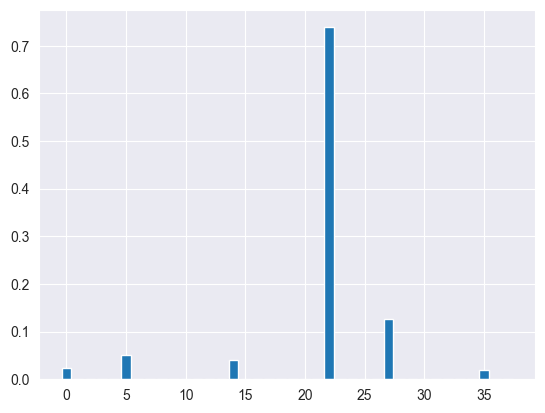

In [25]:
arbolOptimo = gridFinal.best_estimator_
importance = arbolOptimo.feature_importances_

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

# GRAFICAMOS
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Métrica recall: 0.981 



[Text(0.5, 0.9285714285714286, 'CONTAMINANTES <= 114.5\nentropy = 1.532\nsamples = 214\nvalue = [45, 84, 85]'),
 Text(0.2727272727272727, 0.7857142857142857, 'CUMPLE_CON_FLUO <= 0.5\nentropy = 0.955\nsamples = 117\nvalue = [44, 73, 0]'),
 Text(0.18181818181818182, 0.6428571428571429, 'entropy = 0.0\nsamples = 43\nvalue = [0, 43, 0]'),
 Text(0.36363636363636365, 0.6428571428571429, 'CONTAMINANTES <= 39.0\nentropy = 0.974\nsamples = 74\nvalue = [44, 30, 0]'),
 Text(0.18181818181818182, 0.5, 'LONGITUD <= 800.5\nentropy = 0.634\nsamples = 25\nvalue = [4, 21, 0]'),
 Text(0.09090909090909091, 0.35714285714285715, 'entropy = 0.0\nsamples = 21\nvalue = [0, 21, 0]'),
 Text(0.2727272727272727, 0.35714285714285715, 'entropy = 0.0\nsamples = 4\nvalue = [4, 0, 0]'),
 Text(0.5454545454545454, 0.5, 'CALIDAD_N_NO3 <= 1.5\nentropy = 0.688\nsamples = 49\nvalue = [40, 9, 0]'),
 Text(0.45454545454545453, 0.35714285714285715, 'entropy = 0.0\nsamples = 3\nvalue = [0, 3, 0]'),
 Text(0.6363636363636364, 0.357

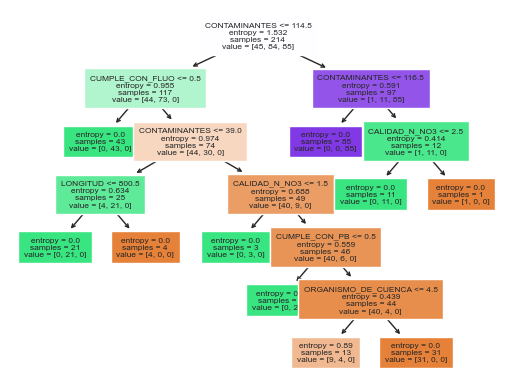

In [37]:
predicciones = arbolOptimo.predict(Xtest)

print("Métrica recall: %.3f \n" %(recall_score(Ytest, predicciones,average='weighted')))
tree.plot_tree(arbolOptimo,feature_names=Xtest.columns, filled = True,fontsize=6)